In [2]:
from google.colab import files
uploaded = files.upload()

Saving Screen_Time_Data.csv to Screen_Time_Data.csv
Saving Sleep_Data.csv to Sleep_Data.csv
Saving Weather_Data.csv to Weather_Data.csv


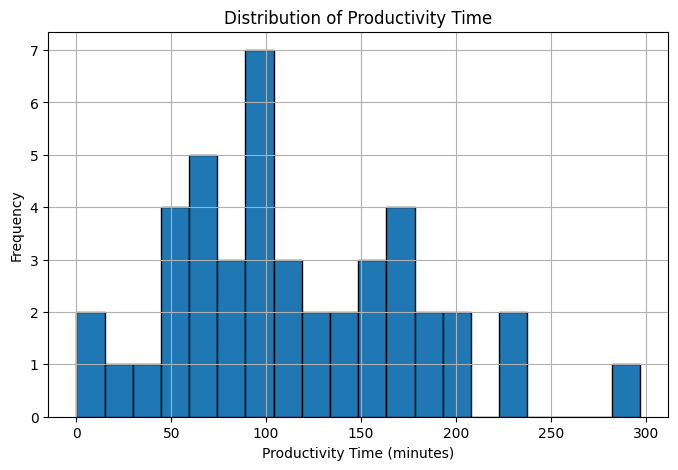

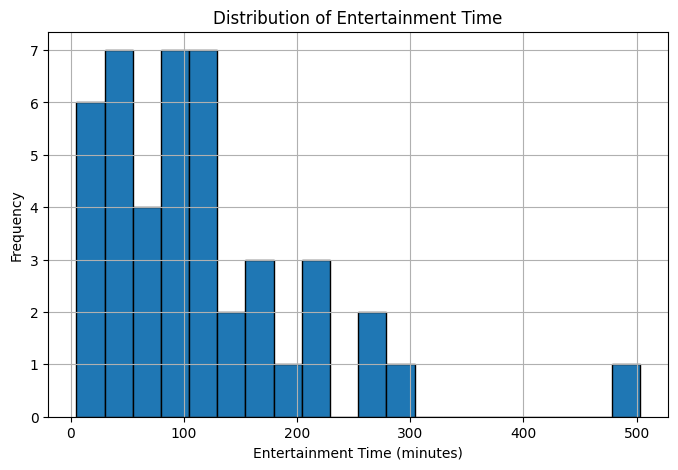

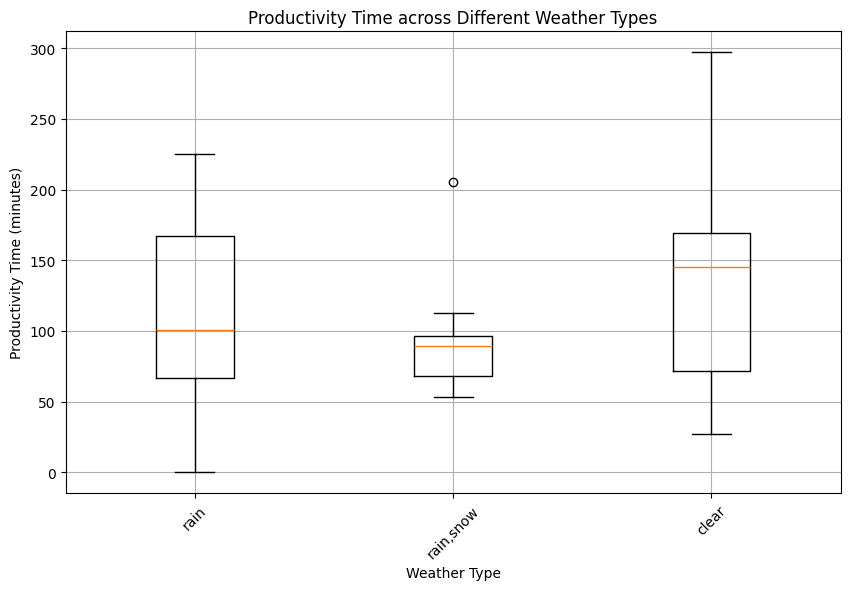

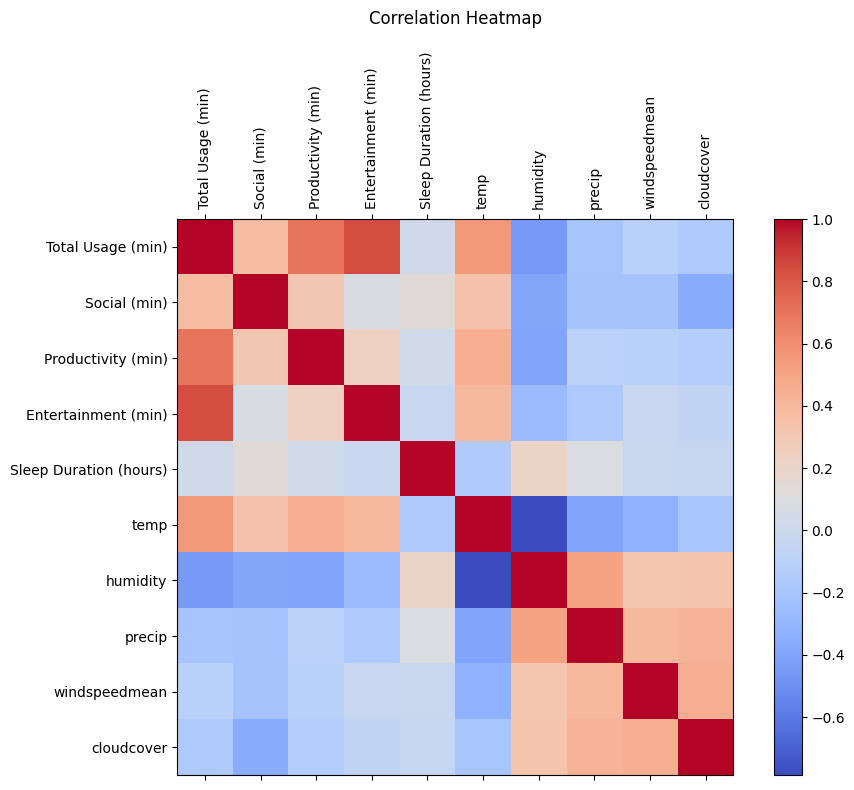

ANOVA Test: Productivity vs Weather Type
F-statistic: 1.131, p-value: 0.3325
Result: No significant differences between weather types (fail to reject H0)
\nChi-Square Test: Dominant Activity vs Exam Period
Chi-square statistic: 0.259, p-value: 0.6110
Result: No significant relationship between dominant activity and exam period (fail to reject H0)


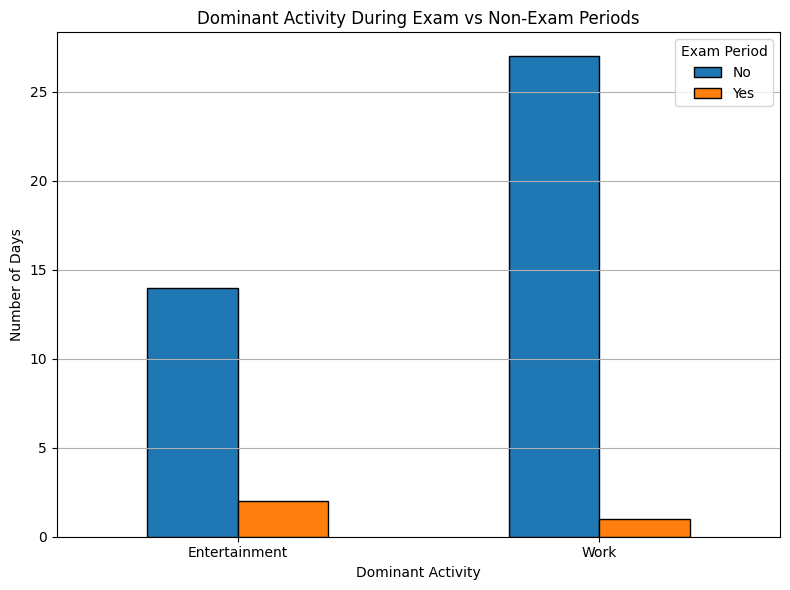

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

screen_time_data = pd.read_csv("Screen_Time_Data.csv")
sleep_data = pd.read_csv("Sleep_Data.csv")
weather_data = pd.read_csv("Weather_Data.csv")

screen_time_data['Date'] = pd.to_datetime(screen_time_data['Date'])
sleep_data['Date'] = pd.to_datetime(sleep_data['Date'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data = weather_data.rename(columns={'datetime': 'Date'})

merged_data = pd.merge(screen_time_data, sleep_data, on='Date', how='inner')
merged_data = pd.merge(merged_data, weather_data, on='Date', how='inner')

merged_data['preciptype'] = merged_data['preciptype'].fillna('clear')

# Distribution of Productivity Time
plt.figure(figsize=(8, 5))
plt.hist(merged_data['Productivity (min)'], bins=20, edgecolor='black')
plt.title('Distribution of Productivity Time')
plt.xlabel('Productivity Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Distribution of Entertainment Time
plt.figure(figsize=(8, 5))
plt.hist(merged_data['Entertainment (min)'], bins=20, edgecolor='black')
plt.title('Distribution of Entertainment Time')
plt.xlabel('Entertainment Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Boxplot of Productivity Time by Weather Type
plt.figure(figsize=(10, 6))
weather_types = merged_data['preciptype'].unique()
weather_dict = {ptype: merged_data[merged_data['preciptype'] == ptype]['Productivity (min)'] for ptype in weather_types}
plt.boxplot(weather_dict.values(), tick_labels=weather_dict.keys())
plt.xticks(rotation=45)
plt.title('Productivity Time across Different Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Productivity Time (minutes)')
plt.grid(True)
plt.show()

# Correlation Heatmap using matplotlib
corr_data = merged_data[['Total Usage (min)', 'Social (min)', 'Productivity (min)',
                         'Entertainment (min)', 'Sleep Duration (hours)', 'temp',
                         'humidity', 'precip', 'windspeedmean', 'cloudcover']]
corr_matrix = corr_data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)
plt.title('Correlation Heatmap', pad=20)
plt.tight_layout()
plt.show()

# Hypothesis Testing 1: ANOVA - Productivity across different weather types
rain = merged_data[merged_data['preciptype'] == 'rain']['Productivity (min)']
rain_snow = merged_data[merged_data['preciptype'] == 'rain,snow']['Productivity (min)']
clear = merged_data[merged_data['preciptype'] == 'clear']['Productivity (min)']

a_stat, a_p = stats.f_oneway(rain, rain_snow, clear)
print("ANOVA Test: Productivity vs Weather Type")
print(f"F-statistic: {a_stat:.3f}, p-value: {a_p:.4f}")
if a_p < 0.05:
    print("Result: Significant differences between weather types (reject H0)")
else:
    print("Result: No significant differences between weather types (fail to reject H0)")

# Hypothesis Testing 6: Chi-Square Test - Work-dominant vs Entertainment-dominant Days
merged_data['Dominant_Activity'] = np.where(merged_data['Productivity (min)'] > merged_data['Entertainment (min)'], 'Work', 'Entertainment')

contingency_table = pd.crosstab(merged_data['Dominant_Activity'], merged_data['Exam Period (3-day)'])

chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)
print("\\nChi-Square Test: Dominant Activity vs Exam Period")
print(f"Chi-square statistic: {chi2_stat:.3f}, p-value: {chi2_p:.4f}")
if chi2_p < 0.05:
    print("Result: Significant relationship between dominant activity and exam period (reject H0)")
else:
    print("Result: No significant relationship between dominant activity and exam period (fail to reject H0)")

# Bar chart
contingency_table.plot(kind='bar', figsize=(8, 6), edgecolor='black')
plt.title('Dominant Activity During Exam vs Non-Exam Periods')
plt.xlabel('Dominant Activity')
plt.ylabel('Number of Days')
plt.xticks(rotation=0)
plt.legend(title='Exam Period', labels=['No', 'Yes'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

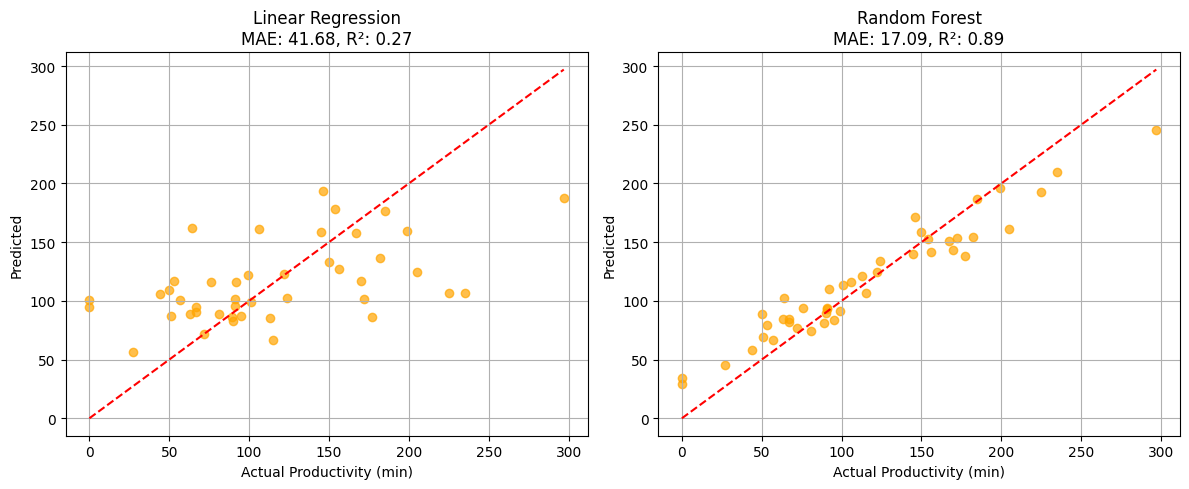

In [6]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 📂 Load datasets
screen_time_data = pd.read_csv("Screen_Time_Data.csv")
sleep_data = pd.read_csv("Sleep_Data.csv")
weather_data = pd.read_csv("Weather_Data.csv")

# 🧹 Clean and merge datasets
screen_time_data['Date'] = pd.to_datetime(screen_time_data['Date'])
sleep_data['Date'] = pd.to_datetime(sleep_data['Date'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data = weather_data.rename(columns={'datetime': 'Date'})

merged_data = pd.merge(screen_time_data, sleep_data, on='Date', how='inner')
merged_data = pd.merge(merged_data, weather_data, on='Date', how='inner')
merged_data['preciptype'] = merged_data['preciptype'].fillna('clear')

# 🔄 Encode categorical and boolean columns
merged_data = pd.get_dummies(merged_data, columns=['preciptype'], drop_first=True)
merged_data['Exam Period (3-day)'] = merged_data['Exam Period (3-day)'].astype(int)

# 🎯 Define features and target
y = merged_data['Productivity (min)']
X = merged_data[[
    'temp', 'humidity', 'cloudcover', 'windspeedmean', 'precip',
    'Sleep Duration (hours)', 'Exam Period (3-day)'
] + [col for col in merged_data.columns if col.startswith('preciptype_')]]

# 🔍 Train models on full dataset
lr_model = LinearRegression()
lr_model.fit(X, y)
y_pred_lr = lr_model.predict(X)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)

# 📊 Evaluate performance
lr_mae = mean_absolute_error(y, y_pred_lr)
lr_r2 = r2_score(y, y_pred_lr)
rf_mae = mean_absolute_error(y, y_pred_rf)
rf_r2 = r2_score(y, y_pred_rf)

# 📈 Plot predictions vs actual values
plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_lr, color='orange', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Productivity (min)')
plt.ylabel('Predicted')
plt.title(f'Linear Regression\nMAE: {lr_mae:.2f}, R²: {lr_r2:.2f}')
plt.grid(True)

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_rf, color='orange', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Productivity (min)')
plt.ylabel('Predicted')
plt.title(f'Random Forest\nMAE: {rf_mae:.2f}, R²: {rf_r2:.2f}')
plt.grid(True)

plt.tight_layout()
plt.savefig("ML_Prediction_vs_Reality.png")
plt.show()
